# IMPORT

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as st
from sklearn.metrics import confusion_matrix
import seaborn as sns
from collections import Counter
import math

#from imblearn.pipeline import Pipeline as ImbalancePipeline
from imblearn.combine import *
from imblearn.over_sampling import *
#from imblearn.under_sampling import RandomUnderSampler 

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
import imblearn
print('The imblearn version is {}.'.format(imblearn.__version__))

import pywt
from scipy.stats import zscore
from scipy.spatial.distance import cdist
from sklearn.ensemble import IsolationForest
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import shap
import csv
from random import randint, seed
from scipy.interpolate import interp1d

The scikit-learn version is 1.1.3.
The imblearn version is 0.12.0.


# Datasets and fuzzy rules definition

In [ ]:
WINDOW_SIZE = 24

#Configure Data path for the datasets

datasets = {'LongHealth':"Data/dataset1-1.csv",
            'SARA':"/Data/dataset2-1.csv"}

# all labels
labels = np.array(['oestrus','calving','lameness','mastitis','LPS','acidosis','other_disease', 'accidents','disturbance','mixing','management_changes','OK'])

#labels without disturbance, mixing or management_changes
labels_anomaly = np.array(['oestrus','calving','lameness','mastitis','LPS','acidosis','other_disease', 'accidents','OK'])

fuzzy_rules = {'oestrus':[-1,2],
               'calving':[-2,7],
               'lameness':[-2,7],
               'mastitis':[-2,7],
               'LPS':[0,7],
               'acidosis':[0,1],
               'other_disease':[-2,7],
               'accidents':[0,7],
               'disturbance':[0,0],
               'mixing':[0,7],
               'management_changes':[0,0]}

# Functions definition

## General functions

In [5]:
def nearest(items, pivot):
    """Obtain the element from items with the shortest distance to pivot, with the distance"""
    res = min(items, key=lambda x: abs(x - pivot))
    return res, pivot-res

In [6]:
def exclude_df(df,df_to_not_check):
    """Exclude the dataframe df_to_not_check from df"""
    
    merged_df = pd.merge(df, df_to_not_check, how='outer', on=['cow', 'date'], indicator=True)

    
    result_df = merged_df[merged_df['_merge'] == 'left_only']

    
    return result_df.drop('_merge', axis=1)

In [7]:
def remove_incomplete_day(rawdata):
    """Delete the data from days not containing 24 hours"""
    cows = rawdata['cow'].unique()

    rmdatecow = []
    for cow in cows:
        datacow = rawdata[rawdata['cow']==cow]
        dates = datacow['date'].unique()

        for d in dates:
            if sum(datacow['date']==d) < 24:
                rmdatecow.append((cow,d))



    return exclude_df(rawdata,pd.DataFrame(rmdatecow,columns=['cow','date']))

## Functions for the fuzzy data

In [8]:
def label_to_bin(label):
    """Convert a list of label (as str name) to a binary value"""
    n = len(labels)
    res = 0
    for i in range(n):
        if labels[n-i-1] in label:
            res+=2**i
    return res

def states_to_label(states):
    """Convert a list of 0,1 to the str associated in labels"""
    return labels[[bit == 1 for bit in states]]

def bin_to_label(bin):
    """Convert a int to a list of labels"""
    bit_list = list('{0:0{width}b}'.format(bin,width=len(labels)))
    int_list = list(map(int,bit_list))
    return states_to_label(int_list)

def maxinterval(I1,I2):
    """get the union of I1 and I2"""
    return [min(I1[0],I2[0]),max(I1[1],I2[1])]

def getfuzzyrule(row):
    """Obtain the fuzzy rules associated for a row (a row can have more than one anomaly)"""
    fuz = [0,0]
    for s in labels[:-1]:
        if row[s]==1:
            fuz = maxinterval(fuz,fuzzy_rules[s])
    return fuz

def getfuzzydays(row):
    """Obtain the fuzzy days associated for a row"""
    fuzzyrule = getfuzzyrule(row)
    date = pd.to_datetime(row["date"])
    return [date + timedelta(days=i) for i in range(fuzzyrule[0],fuzzyrule[1]+1) if i!=0]

def getfuzzydata(data):
    """Obtain all the the fuzzy data of a dataset"""
    abn_data = data[data["OK"]!=1][['cow','date']+labels.tolist()].drop_duplicates()

    fuzzy_data = []
    nabn = abn_data.shape[0]

    for i in range(nabn):
        row = abn_data.iloc[i,:]
        fuzzydays = getfuzzydays(row)
        m = len(fuzzydays)
        for j in range(m):
            fuzzy_data.append((row['cow'],fuzzydays[j].strftime('%Y-%m-%d')))

    return fuzzy_data

## Wavelet function

In [9]:
def decomposition(signal,waveletname,level_reconstruction,level_decomposition_max=None):
    """Decomposition of a signal using the discrete wavelet transform
    - signal : signal to be decomposed
    - waveletname: wavelet used for the transform
    - level_approximation : desired approximation level
    - level_decomposition_max: maximum possible approximation level"""
    coeffs = pywt.wavedec(signal, waveletname, level=level_decomposition_max)
    coeffs_reconstruct = [coeff if j <= level_reconstruction else np.zeros_like(coeff) for j, coeff in enumerate(coeffs)]
    signal_reconstruct = pywt.waverec(coeffs_reconstruct, waveletname)
    return signal_reconstruct

## Dataframe creation

In [10]:
def remove_outliers(data):

    AR = np.reshape(data["ACTIVITY_LEVEL"].values,(-1,24))
    uniquecowsdates = data[['cow','date']].drop_duplicates().reset_index(drop=True)
    indicesremove = np.where(AR.mean(axis=1)>1000)
    return exclude_df(data,uniquecowsdates.iloc[indicesremove])

In [11]:
def get_data_df(datasetkey,remove_disturbance=True):
    """Get the data as a dataframe where each entry corresponds to an hour"""

    rawdata = pd.read_csv(datasets[datasetkey])
    if datasetkey!="LongHealth": # Hours must be 0-23
        rawdata['hour']=rawdata['hour']-1
    data = remove_incomplete_day(rawdata) # Suppression incomplete days
    if remove_disturbance:
        data = data[(data["disturbance"]!=1)&(data["mixing"]!=1) &(data["management_changes"]!=1)].reset_index(drop=True) # Suppression disturbance data
    else:
        data = data[(data["mixing"]!=1) &(data["management_changes"]!=1)].reset_index(drop=True) # Suppression disturbance data

    data = remove_outliers(data).reset_index(drop=True) # Suppression outliers
    data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['hour'].astype(str) + ':00:00')
    fuzzy_data = getfuzzydata(data) # fuzzy data identification
    data["is_fuzzy"] = data.apply(lambda row: 1 if (row['cow'], row['date']) in fuzzy_data else 0, axis=1)
    state_rules = [
    (data['OK'] == 0) & ((data['disturbance'] == 0) | ((data['disturbance'] == 1) & ~(data[labels_anomaly].sum(axis=1) == 0))),  
    ((data['OK'] == 1) | ((data['disturbance'] == 1) & (data[labels_anomaly].sum(axis=1) == 0))) & (data['is_fuzzy'] == 1),  #
    ((data['OK'] == 1) | ((data['disturbance'] == 1) & (data[labels_anomaly].sum(axis=1) == 0))) & (data['is_fuzzy'] == 0)   # 
]
    state_values = [-1, 0, 1]
    data["state"]= np.select(state_rules, state_values, default=np.nan)
    
    cowserie = np.array([],dtype=object)
    cows = data['cow'].unique()
 
    for cow in cows:
        datacow = data[data["cow"]==cow]

        # Sort per datetime
        datacow = datacow.reset_index(drop=True)
        
        datacow['prev_datetime'] = datacow['datetime'].shift(1)
        datacow['diff_hours'] = (datacow['datetime'] - datacow['prev_datetime']).dt.total_seconds() / 3600

        datacowserie = np.empty(datacow.shape[0],dtype=object)
        break_points = datacow[datacow['diff_hours'] != 1].index
        prev_index = 0
        k=-1
        for index in break_points:
            if prev_index < index:
                datacowserie[prev_index:index]='c{},s{}'.format(cow,k)
            prev_index = index
            k+=1
        if prev_index < len(datacow):
            datacowserie[prev_index:]='c{},s{}'.format(cow,k)
        cowserie = np.concatenate((cowserie,datacowserie))
    data["cow_serie"]=cowserie

    return data

In [12]:
def get_windows_df(datasetkey,remove_disturbance=True):
    """Get the data as a dataframe where each entry corresponds to windows"""


    rawdata = pd.read_csv(datasets[datasetkey])
    if datasetkey=="SARA" or datasetkey=='oestrus' or datasetkey=='Bill': # Hours must be 0-23
        rawdata['hour']=rawdata['hour']-1
    data = remove_incomplete_day(rawdata) # Supression incomplete days
    if remove_disturbance: # Suppression disturbance data
        data = data[(data["disturbance"]!=1)&(data["mixing"]!=1) &(data["management_changes"]!=1)].reset_index(drop=True) 
    else:
        data = data[(data["mixing"]!=1) &(data["management_changes"]!=1)].reset_index(drop=True)
    data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['hour'].astype(str) + ':00:00')
    fuzzy_data = getfuzzydata(data) # fuzzy data identification
    data["is_fuzzy"] = data.apply(lambda row: 1 if (row['cow'], row['date']) in fuzzy_data else 0, axis=1)
    
    state_rules = [
    (data['OK'] == 0) & ((data['disturbance'] == 0) | ((data['disturbance'] == 1) & ~(data[labels_anomaly].sum(axis=1) == 0))),  
    ((data['OK'] == 1) | ((data['disturbance'] == 1) & (data[labels_anomaly].sum(axis=1) == 0))) & (data['is_fuzzy'] == 1),  #
    ((data['OK'] == 1) | ((data['disturbance'] == 1) & (data[labels_anomaly].sum(axis=1) == 0))) & (data['is_fuzzy'] == 0)   # 
]
    state_values = [-1, 0, 1]
    data["state"]= np.select(state_rules, state_values, default=np.nan)
    data['state_name'] = data.apply(lambda row: ','.join([col for col in labels_anomaly if row[col] == 1]), axis=1)

    window_size = WINDOW_SIZE
    dataframes_serie = []
    dataframes_serie_label = []
    f = lambda x : -1 if 0 in x else 1


    cows = data['cow'].unique()

    for cow in cows:

        datacow = data[data['cow']==cow]

        datacow = datacow.reset_index(drop=True)
        
        datacow['prev_datetime'] = datacow['datetime'].shift(1)
        datacow['diff_hours'] = (datacow['datetime'] - datacow['prev_datetime']).dt.total_seconds() / 3600

        
        break_points = datacow[datacow['diff_hours'] != 1].index


        dataframes = []
        prev_index = 0
        for index in break_points:
            if prev_index < index:
                dataframes.append(datacow.iloc[prev_index:index].drop(columns=['datetime', 'prev_datetime', 'diff_hours']))
            prev_index = index
        if prev_index < len(datacow):
            dataframes.append(datacow.iloc[prev_index:].drop(columns=['datetime', 'prev_datetime', 'diff_hours']))

        for j, df in enumerate(dataframes):
            windows = []
            windows_label = []
            windows_state=[]
            windows_state_name=[]
            windows_fuzzy = []
            windows_date = []
            windows_hour = []
            windows_disturbance = []
            


            for i in range(len(df) - window_size + 1):
                window = df.iloc[i:i + window_size]["ACTIVITY_LEVEL"].values.copy()
                window_label = df.iloc[i:i + window_size]["OK"].values.copy()
                window_fuzzy = df.iloc[i:i + window_size]["is_fuzzy"].values.copy()
                window_state = df.iloc[i:i + window_size]["state"].values.copy()
                window_state_name = df.iloc[i:i + window_size]["state_name"].values.copy()
                window_disturbance = df.iloc[i:i + window_size]["disturbance"].values.copy()
                windows.append(window)
                windows_state.append(min(window_state))
                windows_state_name.append(max(window_state_name))
                windows_label.append(f(window_label))
                windows_fuzzy.append(int(window_fuzzy.any()))
                windows_disturbance.append(int(window_disturbance.any()))
                windows_date.append(df.iloc[i]["date"])
                windows_hour.append(df.iloc[i]["hour"])

            dataframe_serie = pd.DataFrame(windows,columns = ['h'+str(i) for i in range(WINDOW_SIZE)])
            dataframe_serie['cow']=cow
            dataframe_serie['date']=windows_date
            dataframe_serie['hour']=windows_hour
            dataframe_serie['is_OK']=windows_label
            dataframe_serie['is_fuzzy']=windows_fuzzy
            dataframe_serie['disturbance']=windows_disturbance
            dataframe_serie["state"]=windows_state
            dataframe_serie["state_name"]=windows_state_name
            dataframe_serie['cow_serie']='c{},s{}'.format(cow,j)
            dataframes_serie.append(dataframe_serie)
            dataframes_serie_label.append('c{},s{}'.format(cow,j))

    return pd.concat(dataframes_serie).reset_index(drop=True)


## Attributes dataframe

In [13]:
def stats_attr(df_windows):
    """Obtain a dataframe containing all statistical attributes computed from the windows"""

    X = df_windows.iloc[:,:WINDOW_SIZE].values

    att_names = []
    delta = 12   # Max autocorrelation offset
    att_names.extend(['autocorr' + str(i) for i in range(1,delta)]) 
    att_names.extend(['Moyenne','Ecart-type','Asymetrie','Kurtosis','Minimum','Maximum','Moyenne quad','Mediane','Mode','Q10','Q25','Q75','Q90','RMSSD','EC Moy Fen', 'Moy EC Fen'])
    nbseries = X.shape[0]   # Numbers of series
    n = X.shape[1]   # size of series
    attributes = np.zeros((nbseries,len(att_names)))  


    for l in range(nbseries):
        serie = X[l,:]
        serie_att = []   

        # Autocorrelations 

        mean = np.mean(serie)   # Mean of the serie
        corr0 = (1/n)*np.sum([(serie[i] - mean)**2 for i in range(n)])   # autocorrelation 0

        for i in range(1,delta): 
            corr = (1/n)*np.sum([(serie[j] - mean)*(serie[j+i] - mean) for j in range(n-i)])/corr0 
            serie_att.append(corr) 

        serie_att.append(np.mean(serie))   # Mean
        serie_att.append(np.std(serie))   # STD
        serie_att.append(st.skew(serie))   # Skewness
        serie_att.append(st.kurtosis(serie))   # Kurtosis
        serie_att.append(np.min(serie))   # Minimum
        serie_att.append(np.max(serie))   # Maximum
        serie_att.append(np.sqrt(np.mean(serie**2)))   # Quadratic mean
        serie_att.append(np.median(serie))   # Median
        if isinstance(st.mode(serie).mode, np.ndarray):
            serie_att.append(st.mode(serie).mode[0])   # Mode     
        else:
            serie_att.append(st.mode(serie).mode)   

        # Quantiles 

        serie_att.append(np.quantile(serie,0.1))   # Q10
        serie_att.append(np.quantile(serie,0.25))   # Q25
        serie_att.append(np.quantile(serie,0.75))   # Q75
        serie_att.append(np.quantile(serie,0.90))   # Q90

        # Successive differences

        ds = [serie[i]-serie[i-1] for i in range(1,len(serie))]  

        RMSds = np.sqrt(np.mean([i**2 for i in ds]))   # Quadratic means of successives differences
        serie_att.append(RMSds)

            #Successives windows

        w_size = 6   # Windows size
        w_mean = []  
        w_std = [] 

        for i in range(int(len(serie)/w_size)):
            w_mean.append(np.mean(serie[6*i:6*(i+1)]))   # Mean of the window
            w_std.append(np.std(serie[6*i:6*(i+1)]))   #STD of the window

        serie_att.append(np.std(w_mean))   # STD of means   
        serie_att.append(np.mean(w_std))   # Mean of STD


        attributes[l,:] = serie_att

        
    return pd.DataFrame(attributes,columns=att_names)

In [14]:
def train_test_split_cowseries(X,random_state=None):
    """Split the data into a training and testing set, with a balance in the testing set"""
    
    index_test = X[X['state']!=1].index
    
    all_serie = X["cow_serie"].unique()
    serie_test = np.array([])

    while X.iloc[index_test][X['state']==-1].shape[0] / \
        (X.iloc[index_test][X['state']==-1].shape[0] + X.iloc[index_test][(X["state"]==1)].shape[0]) > 0.5:
        chosen_serie = np.random.choice(all_serie)

        serie_test = np.append(serie_test, chosen_serie)

        all_serie = np.delete(all_serie, np.where(all_serie == chosen_serie))
        
        index_test = index_test.union(X[X['cow_serie'].isin(serie_test)].index)


    index_train = X.index.difference(index_test)


    return index_train,index_test

In [15]:
from collections import deque

def rotate_array(array,n):
    deq = deque(array)
    deq.rotate(n)
    permuted_array = list(deq)
    return permuted_array

In [16]:
waveletnames = ['haar','db2','db3','bior1.3','bior2.2','bior3.1','rbio2.2','rbio3.1','coif1'] # Wavelet list

def get_means_DWT(df_train,waveletname,level_approximation,level_decomposition_max):
    """Get the DWT of the mean AR from the training set, with a specified level of approximation and wavelet"""

    level_reconstruction = level_decomposition_max - level_approximation

    mean_data_h = np.mean(df_train[(df_train['state']==1) & (df_train['hour']==0)].iloc[:,:WINDOW_SIZE].values,axis=0)

    MEAN_DWT_1 = np.array([rotate_array(decomposition(mean_data_h,waveletname,level_reconstruction,level_decomposition_max),-i) for i in range(WINDOW_SIZE)])

    return MEAN_DWT_1

def get_all_means_DWT(df_train,waveletnames):
    """Apply the function above, for all the differents wavelets names and levelz of approximation possible"""
    MEANS_DWT = np.empty((0,WINDOW_SIZE,WINDOW_SIZE))
    for waveletname in waveletnames:
        level_approximation_max = pywt.dwt_max_level(WINDOW_SIZE,waveletname)
        for level_approximation in range(1,level_approximation_max+1):
            MEAN_DWT = get_means_DWT(df_train,waveletname,level_approximation,level_approximation_max)
            MEANS_DWT = np.vstack((MEANS_DWT,[MEAN_DWT]))
    return MEANS_DWT



In [17]:
def DWT_attr(df_windows,MEANS_DWT):
    """Obtain the dataframe of DWT based features"""

    X = df_windows.iloc[:,:WINDOW_SIZE].values

    hour = df_windows["hour"].astype(int)

    att_names = []
    for waveletname in waveletnames:
        level_decomposition_max = pywt.dwt_max_level(WINDOW_SIZE,waveletname)
        for level_approximation in range(1,level_decomposition_max+1):
            att_names.append(waveletname+'|'+str(level_approximation))
    nbseries = X.shape[0]   # Number of series
    n = X.shape[1]   # Size of series
    attributes = np.zeros((nbseries,len(att_names)))  

    for l in range(nbseries): 
        serie = X[l,:]
        serie_att = [] 
        k=0
        for waveletname in waveletnames:
            level_decomposition_max = pywt.dwt_max_level(len(serie),waveletname)
            for level_approximation in range(1,level_decomposition_max+1):
                level_reconstruction = level_decomposition_max-level_approximation
                seriedwt = decomposition(serie,waveletname,level_reconstruction,level_decomposition_max)

                serie_att.append(np.linalg.norm(seriedwt-MEANS_DWT[k,hour[l],:]))

                k+=1



        attributes[l,:] = serie_att

        
    return pd.DataFrame(attributes,columns=att_names)

In [18]:
def remove_highly_correlated_features(df, correlation_threshold):
    """Remove the features with too much correlation with the others"""

    while True:
    
        corr_matrix = df.corr().abs()
        
        
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    
        pairs_to_drop = [(col, row) for col in upper.columns for row in upper.index if upper.loc[row, col] > correlation_threshold]

        if not pairs_to_drop:
            break

       
        mean_corr = corr_matrix.mean()

        to_drop = set()
        for col, row in pairs_to_drop:
            if mean_corr[col] > mean_corr[row]:
                to_drop.add(col)
            else:
                to_drop.add(row)

        df = df.drop(columns=to_drop)

    return df


# Code for a single execution

Data importation and their statistical attributes

Dataset 1: SARA

Dataset 2: LongHealth

In [19]:
from random import seed

seed(0)

keydataset = 'SARA' # Dataset 1
#keydataset = 'LongHealth' # Dataset 2

df_windows = get_windows_df(keydataset,remove_disturbance=True)
df_att_stat = stats_attr(df_windows)

Splitting into the training and testing set

In [20]:
[index_train, index_test] = train_test_split_cowseries(df_windows)
df_train = df_windows.iloc[index_train]
df_test = df_windows.iloc[index_test]

Computation of the Discrete Wavelet Transform (DWT) based features

In [21]:

MEANS_DWT = get_all_means_DWT(df_train,waveletnames)
df_att_DWT = DWT_attr(df_windows,MEANS_DWT)

Creation of X_train and X_test, used in IsolationForest

In [22]:
df_att = pd.concat((df_att_stat,df_att_DWT),axis=1)

X_train = df_att.iloc[index_train]
X_test = df_att.iloc[index_test]
features_reduc_correl = remove_highly_correlated_features(df_att, 0.9).columns

Model training

In [23]:

clf = IsolationForest(random_state=0,n_estimators=100,max_features=1.0)
clf.fit(X_train.loc[:,features_reduc_correl])


IsolationForest(random_state=0)

Prediction on the non fuzzy data and scores results

In [25]:
index_nofuzzy = df_test[(df_test["is_OK"]==-1) | (df_test["is_fuzzy"]==0)].index
pred = clf.predict(X_test.loc[index_nofuzzy,features_reduc_correl])
acc_score = accuracy_score(df_test.loc[index_nofuzzy,:]["is_OK"].values,pred)
rec_score = recall_score(df_test.loc[index_nofuzzy,:]["is_OK"].values,pred,pos_label=-1)
prec_score = precision_score(df_test.loc[index_nofuzzy,:]["is_OK"].values,pred,pos_label=-1)
f1score = f1_score(df_test.loc[index_nofuzzy,:]["is_OK"].values,pred,pos_label=-1)

print("Accuracy score:",acc_score)
print("Recall score:",rec_score)
print("Precision score:",prec_score)
print("F1 score:",acc_score)

Accuracy score: 0.5293031841255191
Recall score: 0.10183875530410184
Precision score: 0.6153846153846154
F1 score: 0.5293031841255191


# Obtention of the histogram of the distance of detection

In [26]:
key = 'SARA'
#key = 'LongHealth'
df_data = get_data_df(key,remove_disturbance=True)

Execution with NB_ITER iterations, with regard to the distance of detections

In [ ]:
NB_ITER = 10

seed(0)

df_windows = get_windows_df(key,remove_disturbance=True)
df_data = get_data_df(key,remove_disturbance=True)
df_att_stat = stats_attr(df_windows)
df_data_disturbance=get_data_df(key,remove_disturbance=False)
df_windows_disturbance = get_windows_df(key,remove_disturbance=False)
df_att_stat_disturbance = stats_attr(df_windows_disturbance)

all_df_detections = []

for iter_instance in range(NB_ITER):

    [index_train, index_test] = train_test_split_cowseries(df_windows)
    df_train = df_windows.iloc[index_train]
    df_test = df_windows.iloc[index_test]
    
    MEANS_DWT = get_all_means_DWT(df_train,waveletnames)
    df_att_DWT = DWT_attr(df_windows,MEANS_DWT)

    df_att = pd.concat((df_att_stat,df_att_DWT),axis=1)
    
    X_train = df_att.iloc[index_train]
    X_test = df_att.iloc[index_test]

    features_reduc_correl = remove_highly_correlated_features(df_att, 0.9).columns

    clf = IsolationForest(n_estimators=100,max_features=1.0)
    clf.fit(X_train.loc[:,features_reduc_correl])

    df_att_DWT_disturbance = DWT_attr(df_windows_disturbance,MEANS_DWT)
    df_att_disturbance = pd.concat((df_att_stat_disturbance,df_att_DWT_disturbance),axis=1)
    
    cowserie = df_windows_disturbance["cow_serie"].unique()
    cows = df_windows_disturbance['cow'].unique()
    threshold = 0
    k=0
    f = lambda x : 2*(x>=0)-1
    hist_verif_before = []
    hist_verif_after = []
    cows_abnormal= []
    dates_abnormal =[]
    false_FN = 0
    cows_detection = []
    date_detection = []
    precision_detection = []
    dist_detection = []

    all_cowsdaystates = df_data_disturbance[['cow','date','state']].drop_duplicates()
    all_cows_test = []
    all_days_test = []
    all_state_test = []
    for cow in cows[:]:
        df_windows_cow = df_windows_disturbance[df_windows_disturbance['cow']==cow]
        df_data_cow = df_data_disturbance[df_data_disturbance['cow']==cow]
        
        df_windows_cow['datetime'] = pd.to_datetime(df_windows_cow['date'] + ' ' + df_windows_cow['hour'].astype(int).astype(str) + ':00:00')
        df_windows_cow['prev_datetime'] = df_windows_cow['datetime'].shift(1)
        df_windows_cow['diff_hours'] = (df_windows_cow['datetime'] - df_windows_cow['prev_datetime']).dt.total_seconds() / 3600

        n_windows = df_windows_cow.shape[0]
        
        index_serie = df_windows_cow.index

        start_date = df_windows_cow["datetime"].iloc[0]
        end_date = df_windows_cow["datetime"].iloc[-1]

        dates_with_anomalies = df_windows_cow[(df_windows_cow['state']==-1) & (df_windows_cow['hour']==0)]['date']

        hourly_timestamps = np.array([(start_date + timedelta(hours=i)) for i in range((end_date - start_date).days*24 + 24)])
        

        pred_point = np.zeros_like(hourly_timestamps)
        N = np.zeros_like(hourly_timestamps)

        pred_serie = clf.predict(df_att_disturbance.loc[index_serie,features_reduc_correl])


        for i in range(len(pred_serie)):
            mydate = df_windows_cow.iloc[i]['datetime']
            j = np.where(hourly_timestamps ==mydate)[0][0]
            pred_point[j:j+WINDOW_SIZE]+=pred_serie[i]
            N[j:j+WINDOW_SIZE]+=1

        pred_point = np.divide(pred_point,N,where=(N!=0))
        true_states = np.array([f(df_data_cow[df_data_cow['datetime']==hourly_timestamps[i]]['state'].values[0]) \
    if hourly_timestamps[i] in df_data_cow['datetime'].values else None for i in range(hourly_timestamps.shape[0])])
        disturbances = np.array([df_data_cow[df_data_cow['datetime']==hourly_timestamps[i]]['disturbance'].values[0] \
    if hourly_timestamps[i] in df_data_cow['datetime'].values else None for i in range(hourly_timestamps.shape[0])])

        df_cow_reconstructed = pd.DataFrame({"state":true_states,"datetime":hourly_timestamps,\
                                                    'hour':[d.hour for d in hourly_timestamps],\
                                                'date':[d.strftime('%Y-%m-%d') for d in hourly_timestamps],\
                                                'pred_state':pred_point,'disturbances':disturbances})
        

        df_cow_reconstructed['alarm'] = df_cow_reconstructed['pred_state'] < threshold
        point_alarm = df_cow_reconstructed.groupby('date')['alarm'].apply(lambda x: (x == True).mean())
        days_alarm = point_alarm[point_alarm >=0.5].index

        for d in dates_with_anomalies:
            cows_abnormal.append(cow)
            dates_abnormal.append(d)

        for d in days_alarm:
            cows_detection.append(cow)
            date_detection.append(d)
            if dates_with_anomalies.shape[0] > 0: #If there were an anomaly
  
                distdate = nearest(pd.to_datetime(dates_with_anomalies),datetime.strptime(d, '%Y-%m-%d'))[1].total_seconds() / 3600 / 24
                dist_detection.append(distdate)

            else:

                dist_detection.append(np.nan)


    df_cowdaysstates_test = pd.DataFrame({'cow':all_cows_test,'date':all_days_test,'state':all_state_test})

    df_detections = pd.DataFrame({'cow':cows_detection,'date':date_detection,'dist_detection':dist_detection})

    all_df_detections.append(df_detections)
    print('Iteration n°',iter_instance)

Iteration n° 0


Creation of the histogram

In [28]:
def hist_dist_detection_normalized(y,x,clip_range=(-8,8)):
    x_clipped = np.clip(x,clip_range[0],clip_range[1])
    y_clipped = np.clip(y,clip_range[0],clip_range[1])
    
    freq_x = Counter(x_clipped)
    freq_y = Counter(y_clipped)

    bins = np.arange(clip_range[0],clip_range[1]+1)
    num_nan = np.isnan(y_clipped).sum()


    keys = sorted(set(x_clipped))
    normalized_y = {key: (freq_y[key] / freq_x[key]) if key in freq_x and freq_x[key] > 0 else 0 for key in keys}

    
    sum_normalized_y = sum(normalized_y.values())
    normalized_y = {key: value / sum_normalized_y for key, value in normalized_y.items()}

    normalized_y_freq = np.array([normalized_y[key] for key in keys])

    counts, edges = np.histogram(normalized_y_freq, bins=bins)

    labels = [f"{int(edge)}" for edge in edges[:-1]]
    labels[0] = "< {}".format(clip_range[0])
    labels[-1] = "> {}".format(clip_range[1])


    labels.append("FP")
    counts = np.append(counts, num_nan) 


    return bins,normalized_y_freq, counts[-1]


In [29]:
all_cowsdaystates = df_data_disturbance[['cow','date','state']].drop_duplicates()
cowsdays_unhealthy = all_cowsdaystates[all_cowsdaystates['state']==-1]

cows_with_ano = cowsdays_unhealthy['cow'].unique()
total_hist = np.array([])

for cow in cows_with_ano[:]:
    k=0
    daystates = pd.to_datetime(all_cowsdaystates[all_cowsdaystates['cow']==cow]['date'])
    days_unhealthy = pd.to_datetime(cowsdays_unhealthy[cowsdays_unhealthy['cow']==cow]['date'])
    sub_hist = np.zeros(daystates.shape[0])
    for d in daystates:
        sub_hist[k]=nearest(days_unhealthy,d)[1].total_seconds() / 3600 / 24
        k+=1
    total_hist = np.concatenate((total_hist,sub_hist))

In [30]:

hist_with_means = np.zeros((NB_ITER,17))
nan_counts = np.zeros(NB_ITER)
k=0
for df_detections in all_df_detections:
    hist_with_means[k,:] = hist_dist_detection_normalized(df_detections['dist_detection'],total_hist)[1]
    nan_counts[k]=hist_dist_detection_normalized(df_detections['dist_detection'],total_hist)[2]
    k+=1

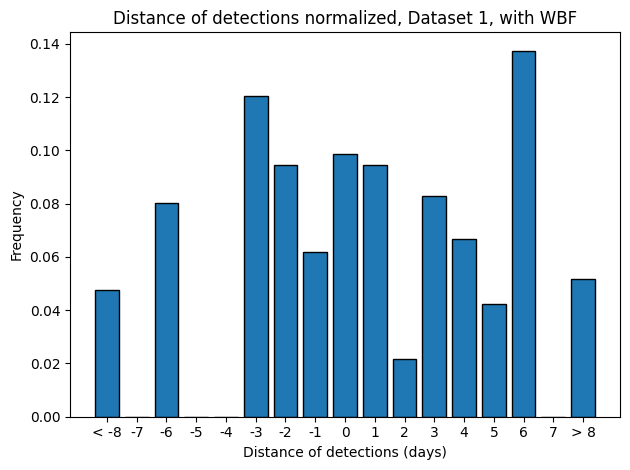

[0.04764615 0.         0.08020436 0.         0.         0.12030653
 0.09435807 0.06169566 0.09849658 0.09435807 0.02167685 0.08297002
 0.06683696 0.04221282 0.13749318 0.         0.05174475]


In [31]:
hist_with_means.mean(axis=0)
hist_with_means.std(axis=0)

clip_range=(-8,8)
labels_plot = [f"{int(edge)}" for edge in range(-8,8+1)]
labels_plot[0] = "< {}".format(clip_range[0])
labels_plot[-1] = "> {}".format(clip_range[1])

plt.bar(labels_plot, hist_with_means.mean(axis=0), yerr=hist_with_means.std(axis=0),edgecolor="black")
plt.xticks(rotation=0) 
plt.xlabel("Distance of detections (days)")
plt.ylabel("Frequency",)
plt.title("Distance of detections normalized, Dataset 1, with WBF")
plt.tight_layout()
plt.show()

print(hist_with_means.mean(axis=0))

# Check of the Isolation Forest parameters



In [32]:

tree_numbers_list = [50,75,100,200,300,400,500]
max_features_list = [0.25,0.5,0.75,1.0]
corr_threshold_list = [0.2,0.35,0.5,0.65,0.8,0.85,0.9]


df_windows = get_windows_df("SARA",remove_disturbance=True)
df_att_stat = stats_attr(df_windows)

In [ ]:
from random import seed, randint

seed(0)
NB_ITER = 20
max_score = 0
max_score_tree = 0
max_score_MF = 0
max_score_corr = 0
with open('tototototo.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    # Écriture de l'en-tête
    writer.writerow(['corr_threshold', 'max_features', 'tree_numbers','exec', 'acc_score'])
    

    for corr_threshold in corr_threshold_list:
        for max_features in max_features_list:
            for tree_numbers in tree_numbers_list:
                acc_scores = []
                k_iter = 0
                stop = False
                while k_iter < NB_ITER and not(stop):
                    print("iter n",k_iter+1)
                    t_exec = time.time()

                    [index_train, index_test] = train_test_split_cowseries(df_windows)
                    df_train = df_windows.iloc[index_train]
                    df_test = df_windows.iloc[index_test]
                                        

                    MEANS_DWT = get_all_means_DWT(df_train,waveletnames)
                    df_att_DWT = DWT_attr(df_windows,MEANS_DWT)
                    df_att = pd.concat((df_att_stat,df_att_DWT),axis=1)

                    X_train = df_att.iloc[index_train]
                    X_test = df_att.iloc[index_test]

                    features_reduc_correl = remove_highly_correlated_features(df_att, 0.9).columns

                    clf = IsolationForest(random_state=0,n_estimators=100,max_features=1.0)
                    clf.fit(X_train.loc[:,features_reduc_correl])
                    


                    index_nofuzzy = df_test[(df_test["is_OK"]==-1) | (df_test["is_fuzzy"]==0)].index
                    X_test_nofuzzy = X_test.loc[index_nofuzzy,:]
                    acc_score = accuracy_score(df_test.loc[index_nofuzzy,:]["is_OK"].values,clf.predict(X_test_nofuzzy.loc[:,features_reduc_correl]))
                    acc_scores.append(acc_score)
                    writer.writerow([corr_threshold, max_features, tree_numbers,k_iter, acc_score])
                    k_iter+=1
                    if k_iter>2:
                        cumulated_score_mean = np.cumsum(acc_scores) / np.arange(1, len(acc_scores) + 1)
                        if np.sum(np.abs(np.diff(cumulated_score_mean)[-5:])<0.001)==5:
                            stop = True
                    

                
                print(acc_scores)
                print(corr_threshold)
                print(max_features)
                print(tree_numbers)
                if np.mean(acc_scores) > max_score:
                    max_score = np.mean(acc_scores)
                    max_score_tree = tree_numbers
                    max_score_MF = max_features
                    max_score_corr = corr_threshold
                print("new max score : ",max_score)
                print('_____')

# Test of the scores value, with and without wavelet-based features


In [ ]:
def measure_acc(df_windows,nb_train_test_split,nb_IF_exec,tree_numbers,max_features,corr_threshold,filename,withDWT = True):
    df_att_stat = stats_attr(df_windows)



    df = pd.DataFrame(columns=["train_test","exec","score"])
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Écriture de l'en-tête
        writer.writerow(['train_test', 'exec','accuracy_score','recall_score','precision_score','f1_score'])
        k=0
        stopall=False
        i_state = 0
        while k<nb_train_test_split and not(stopall):
            
            print('train_test n',k)      

            [index_train, index_test] = train_test_split_cowseries(df_windows)
            df_train = df_windows.iloc[index_train]
            df_test = df_windows.iloc[index_test]

            if withDWT:
                MEANS_DWT = get_all_means_DWT(df_train,waveletnames)
                df_att_DWT = DWT_attr(df_windows,MEANS_DWT)
                df_att = pd.concat((df_att_stat,df_att_DWT),axis=1)
            else:
                df_att = df_att_stat         


            X_train = df_att.iloc[index_train]
            X_test = df_att.iloc[index_test]

            features_reduc_correl = remove_highly_correlated_features(df_att, corr_threshold).columns


            acc_scores = []
            k_iter=0
            stop=False

            tps_exec=time.time()
            while k_iter<nb_IF_exec and not(stop):
                print('k_iter=',k_iter)
                clf = IsolationForest(random_state=i_state, n_estimators=tree_numbers,max_features=max_features)
                clf.fit(X_train.loc[:,features_reduc_correl])

                index_nofuzzy = df_test[(df_test["is_OK"]==-1) | (df_test["is_fuzzy"]==0)].index
                pred = clf.predict(X_test.loc[index_nofuzzy,features_reduc_correl])
                acc_score = accuracy_score(df_test.loc[index_nofuzzy,:]["is_OK"].values,pred)
                rec_score = recall_score(df_test.loc[index_nofuzzy,:]["is_OK"].values,pred,pos_label=-1)
                prec_score = precision_score(df_test.loc[index_nofuzzy,:]["is_OK"].values,pred,pos_label=-1)
                f1score = f1_score(df_test.loc[index_nofuzzy,:]["is_OK"].values,pred,pos_label=-1)
                acc_scores.append(acc_score)
                df.loc[len(df)] = {'train_test':k,'exec':k_iter,'acc_score':acc_score}
                writer.writerow([k,k_iter,acc_score, rec_score, prec_score, f1score])
                k_iter+=1
                i_state+=1
                if k_iter>2:
                    cumulated_score_mean = np.cumsum(acc_scores) / np.arange(1, len(acc_scores) + 1)
                    if np.sum(np.abs(np.diff(cumulated_score_mean)[-5:])<0.001)==5:
                        stop = True
            k+=1
            df_grouped = df.groupby('train_test').mean()["score"]
            cumulated_score_mean_total = np.cumsum(df_grouped) / np.arange(1, len(df_grouped) + 1)
            tps_exec = time.time() - tps_exec
            print("exec_time :",tps_exec)
            if np.sum(np.abs(np.diff(cumulated_score_mean_total)[-5:])<0.001)==5:
                        
                stopall = True

In [ ]:


seed(0)

nb_train_test_split = 2
nb_IF_exec = 2
max_features=1.0
tree_numbers = 100
corr_threshold = 0.9

for keydataset in ['SARA','LongHealth']:
    df_windows = get_windows_df(keydataset,remove_disturbance=True)

       # WITH WAVELETS
    
    measure_acc(df_windows,nb_train_test_split,nb_IF_exec,tree_numbers,max_features,corr_threshold,\
                filename='scores_DWT_'+keydataset+'.csv',withDWT=True)


    # WITHOUT WAVELETS
    measure_acc(df_windows,nb_train_test_split,nb_IF_exec,tree_numbers,max_features,corr_threshold,\
                filename='scores_noDWT_'+keydataset+'.csv',withDWT=False)

# Features contributions with SHAP Value

In [ ]:
import csv
import shap
from sklearn.ensemble import IsolationForest

seed(0)

nb_train_test_split = 1
nb_IF_exec = 5
max_features=1.0
tree_numbers = 100
corr_threshold = 0.9

for keydataset in ['SARA','LongHealth']:
                        
    df_windows = get_windows_df(keydataset)
    df_att_stat = stats_attr(df_windows)

    with open('SHAP_measure_'+keydataset+'.csv', mode='w', newline='') as file:
        i_state=0
        writer = csv.writer(file)
        # Écriture de l'en-tête
        writer.writerow(['classifier_name', 'dataset_name', 'accuracy'])
        # Écriture des lignes de données
        for k in range(nb_train_test_split):
     
            [index_train, index_test] = train_test_split_cowseries(df_windows)
            df_train = df_windows.iloc[index_train]
            df_test = df_windows.iloc[index_test]
                                

            MEANS_DWT = get_all_means_DWT(df_train,waveletnames)
            df_att_DWT = DWT_attr(df_windows,MEANS_DWT)
            df_att = pd.concat((df_att_stat,df_att_DWT),axis=1)

            X_train = df_att.iloc[index_train]
            X_test = df_att.iloc[index_test]

            features_reduc_correl = remove_highly_correlated_features(df_att, 0.9).columns

            for j in range(nb_IF_exec):
                tps_exec = time.time()
                clf = IsolationForest(random_state=i_state,n_estimators=tree_numbers,max_features=max_features)
                clf.fit(X_train.loc[:,features_reduc_correl])
                explainer = shap.TreeExplainer(clf)
                shap_values = explainer.shap_values(X_test.loc[:,features_reduc_correl])
                mean_shap_values = np.mean(np.abs(shap_values),axis=0)
                tps_exec = time.time() - tps_exec
                print("k=",k,"j=",j,";tps_exec=",tps_exec)
                i_state+=1
                for i in range(len(features_reduc_correl)):
                    writer.writerow([features_reduc_correl[i], f'exec_{nb_IF_exec*k+j}', mean_shap_values[i]])